# Classifier

In [1]:
C_USE_CACHE_FILE        = "long-run-server-28-01.pkl"

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [3]:
# Install and import demoji
# Dont exists on conda
import sys
!{sys.executable} -m pip install demoji

import demoji
demoji.download_codes()

import re

... OK (Got response in 0.44 seconds)
Writing emoji data to /home/jovyan/.demoji/codes.json ...
... OK


In [4]:
import nltk

# Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [6]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

In [7]:
# Set plot style
# TODO: Test different style
plt.style.use('ggplot')

In [8]:
dir_var                 = "./work/notebooks/"
dir_var_output          = dir_var + "output/"
dir_var_pandas_cache    = dir_var + "cache/pandas/"

In [9]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

In [10]:
def gloReplaceGermanChars(inputText):

    inputText = inputText.replace("ö", "oe")
    inputText = inputText.replace("ü", "ue")
    inputText = inputText.replace("ä", "ae")

    inputText = inputText.replace("Ö", "Oe")
    inputText = inputText.replace("Ü", "Ue")
    inputText = inputText.replace("Ä", "Ae")

    inputText = inputText.replace("ß", "ss")
    
    return inputText

In [11]:
# Rm unsafe chars
def gloConvertToSafeString(text):
    text = demoji.replace(text, "")
    text = gloReplaceGermanChars(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = gloConvertToSafeString(chatName)
    return chatName[:30]

In [12]:
def gloGetStopWordsList(filterList):

    stopwWorldsList = []

    deWordsList = nltk.corpus.stopwords.words('german')

    enWordsList = nltk.corpus.stopwords.words('english')

    aStopwords = []
    with open(dir_var + "additionalStopwords.txt") as file:
        for line in file: 
            line = line.strip()
            if(line != ""):
                aStopwords.append(line)

    for s in filterList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in deWordsList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in enWordsList:
        stopwWorldsList.append(s)

    for s in aStopwords:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    return stopwWorldsList

In [13]:
# Load from cachea
dfAllDataMessages = pd.read_pickle(dir_var_pandas_cache + C_USE_CACHE_FILE)

In [14]:
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procEvalIsValidText == True]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procTDCleanText != ""]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procTDTextLength > 5]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procChatType == "public_channel"]

dfAllDataMessages = dfAllDataMessages[dfAllDataMessages["from"].str.contains("QUER") == False]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages["from"].str.contains("Quer") == False]

dfAllDataMessages["from"] = dfAllDataMessages["from"].apply(gloConvertToSafeChatName)

dfAllDataMessages["from"].value_counts()

Oliver Janich oeffentlich    30740
ATTILA HILDMANN              22885
Eva Herman Offiziell         14067
Xavier Naidoo inoffiziell     9103
Name: from, dtype: int64

In [15]:
dfAllDataMessages.columns

Index(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'text',
       'from', 'from_id', 'file', 'media_type', 'mime_type',
       'duration_seconds', 'edited', 'thumbnail', 'width', 'height', 'photo',
       'forwarded_from', 'poll.question', 'poll.closed', 'poll.total_voters',
       'poll.answers', 'sticker_emoji', 'message_id', 'reply_to_message_id',
       'location_information.latitude', 'location_information.longitude',
       'live_location_period_seconds', 'via_bot', 'performer',
       'procChatFilePath', 'procChatType', 'procIsJsonFormatted',
       'tmpExtractedTD', 'procTDText', 'procTDURLs', 'procTDHashtags',
       'procTDBolds', 'procTDItalics', 'procTDUnderlines', 'procTDEmails',
       'procTDCleanText', 'procTDEmojis', 'procTDEmojisDesc', 'procTDSafeText',
       'procTDSafeLowercaseText', 'procTDTextLength', 'procEvalIsValidText',
       'procEvalContainsPhoto', 'procEvalContainsFile', 'procEvalIsEdited',
       'procEvalIsForwarded', 'procEvalContains

## Let's get started...

In [16]:
df = dfAllDataMessages[[
 'date',
 'from',
 'procEvalIsValidText',
 'procIsJsonFormatted',
 'procTDCleanText',
 'procTDSafeText',
 'procTDSafeLowercaseText',
 'procTDTextLength',
 'procEvalContainsUrl',
 'procTDURLs',
 'procEvalContainsHashtag',
 'procTDHashtags',
 'procEvalContainsBoldItem',
 'procTDBolds',
 'procEvalContainsItalicItem',
 'procTDItalics',
 'procEvalContainsUnderlineItem',
 'procTDUnderlines',
 'procEvalContainsEmailItem',
 'procTDEmails',
 'procEvalContainsEmojiItem',
 'procTDEmojis',
 'procTDEmojisDesc',
 'procEvalContainsPhoto',
 'procEvalContainsFile',
 'procEvalIsEdited',
 'procEvalIsForwarded',
 'procPipeline-ner-xlm-roberta',
 'procPipeline-ner-bert',
 'procPipeline-sen-bert',
 'procPipeline-sentiment']].copy()

In [17]:
df['clFrom']    = df['from']
df['clFromId']  = df['from'].factorize()[0]
df['clText']    = df['procTDCleanText']

In [18]:
dfFromId            = df[['clFrom', 'clFromId']].drop_duplicates().sort_values('clFromId')

dictFrom_to_id      = dict(dfFromId.values)
dictId_to_from      = dict(dfFromId[['clFromId', 'clFrom']].values)

In [19]:
dictId_to_from

{0: 'ATTILA HILDMANN ',
 1: 'Oliver Janich oeffentlich',
 2: 'Eva Herman Offiziell',
 3: 'Xavier Naidoo inoffiziell'}

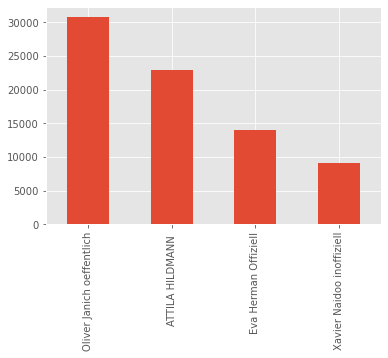

In [20]:
_ = df["clFrom"].value_counts().plot.bar()

### TODO

Thank you https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

```
len(df.index)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words=gloGetStopWordsList([])) # , stop_words='german' TODO: Stop Words

features    = tfidf.fit_transform(df["clText"]).toarray()
labels      = df["clFromId"]

features.shape

from sklearn.feature_selection import chi2
import numpy as np

N = 2
for clFrom, clFromId in sorted(dictFrom_to_id.items()):

    print("Got " + str(clFrom) + "/" + str(clFromId) + " and " + str(N))

    features_chi2   = chi2(features, labels == clFromId)
    indices         = np.argsort(features_chi2[0])
    feature_names   = np.array(tfidf.get_feature_names())[indices]

    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(clFrom))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
```

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['clText'], df['clFrom'], random_state = 42, test_size=0.20)

print("Train size:\t" + str(len(X_train.index)))
print("Test size:\t" + str(len(X_test.index)))

Train size:	61436
Test size:	15359


In [22]:
gloStartStopwatch("Transform messages")

count_vect          = CountVectorizer()
tfidf_transformer   = TfidfTransformer()

# Transform and fit train
X_train_counts      = count_vect.fit_transform(X_train)
X_train_tfidf       = tfidf_transformer.fit_transform(X_train_counts)

# Transform test
X_test_counts       = count_vect.transform(X_test)
X_test_tfidf        = tfidf_transformer.transform(X_test_counts)

gloStopStopwatch("Transform messages")

[Stopwatch started >>Transform messages<<]
[Stopwatch stopped >>Transform messages<< (3.410s)]


In [23]:
def trainAndEvalModel(model, outputFilename):

    gloStartStopwatch("- Train now model " + str(model))
    model.fit(X_train_tfidf, y_train)
    gloStopStopwatch("- Train now model " + str(model))

    searchStrings = ["Folge Attila Hildmann", "Liebe Eva", "Premium Kanal"]

    for sS in searchStrings:

        sS = str(sS)
        print()
        print("Who has written '" + sS + "'?")
        t = tfidf_transformer.transform(count_vect.transform([sS]))
        r = model.predict(t)
        print(str(r))

    y_pred_train        = model.predict(X_train_tfidf)
    y_pred_test         = model.predict(X_test_tfidf)

    print()
    print("Train Score:\t"  + str(accuracy_score(y_true=y_train, y_pred=y_pred_train)))
    print("Test Score:\t"   + str(accuracy_score(y_true=y_test, y_pred=y_pred_test)))

    print()
    print("Confusion Matrix on test:")
    conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred_test)
    fig, ax  = plt.subplots(figsize=(10,10))

    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=dfFromId.clFrom.values, yticklabels=dfFromId.clFrom.values)
                
    plt.ylabel('Is')
    plt.xlabel('Predicted')

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

    plt.show()

[Stopwatch started >>- Train now model LinearSVC()<<]
[Stopwatch stopped >>- Train now model LinearSVC()<< (3.537s)]

Who has written 'Folge Attila Hildmann'?
['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?
['Eva Herman Offiziell']

Who has written 'Premium Kanal'?
['Oliver Janich oeffentlich']

Train Score:	0.9304316687284329
Test Score:	0.7383293183149945

Confusion Matrix on test:


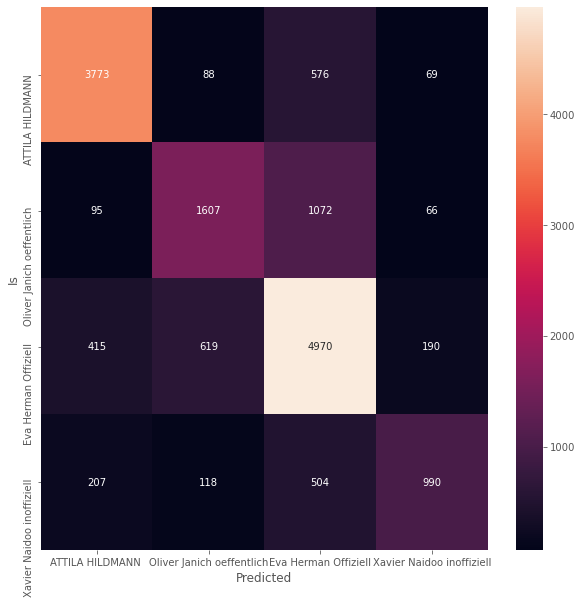

In [24]:
trainAndEvalModel(LinearSVC(), "class-linearsvc.svg")

[Stopwatch started >>- Train now model MultinomialNB()<<]
[Stopwatch stopped >>- Train now model MultinomialNB()<< (0.315s)]

Who has written 'Folge Attila Hildmann'?
['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?
['Eva Herman Offiziell']

Who has written 'Premium Kanal'?
['Oliver Janich oeffentlich']

Train Score:	0.7423009310501986
Test Score:	0.7122208477114396

Confusion Matrix on test:


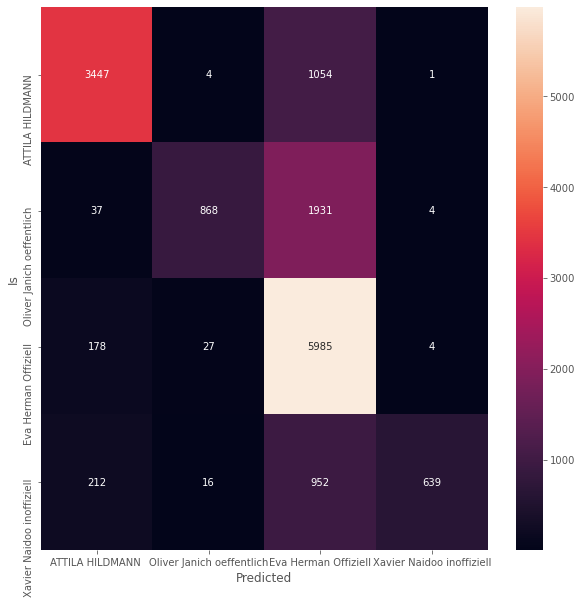

In [25]:
trainAndEvalModel(MultinomialNB(), "class-multinomialnb.svg")

In [26]:
trainAndEvalModel(LogisticRegression(), "class-logisticregression.svg")

[Stopwatch started >>- Train now model LogisticRegression()<<]


KeyboardInterrupt: 

[Stopwatch started >>- Train now model MLPClassifier()<<]

/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Stopwatch stopped >>- Train now model MLPClassifier()<< (49838.454s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['Oliver Janich oeffentlich']

Train Score:	0.9628920888548693

Test Score:	0.6928817451205511

Confusion Matrix on test:

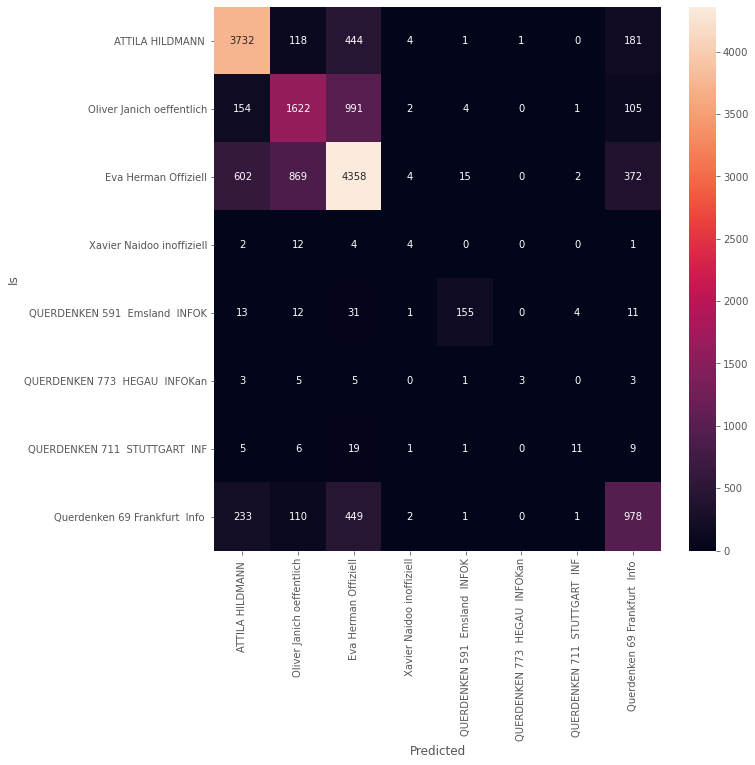

In [27]:
trainAndEvalModel(MLPClassifier(), "class-mlp.svg")

[Stopwatch started >>- Train now model DecisionTreeClassifier()<<]

[Stopwatch stopped >>- Train now model DecisionTreeClassifier()<< (103.035s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['Oliver Janich oeffentlich']

Train Score:	0.9632907557128961

Test Score:	0.608814899859676

Confusion Matrix on test:

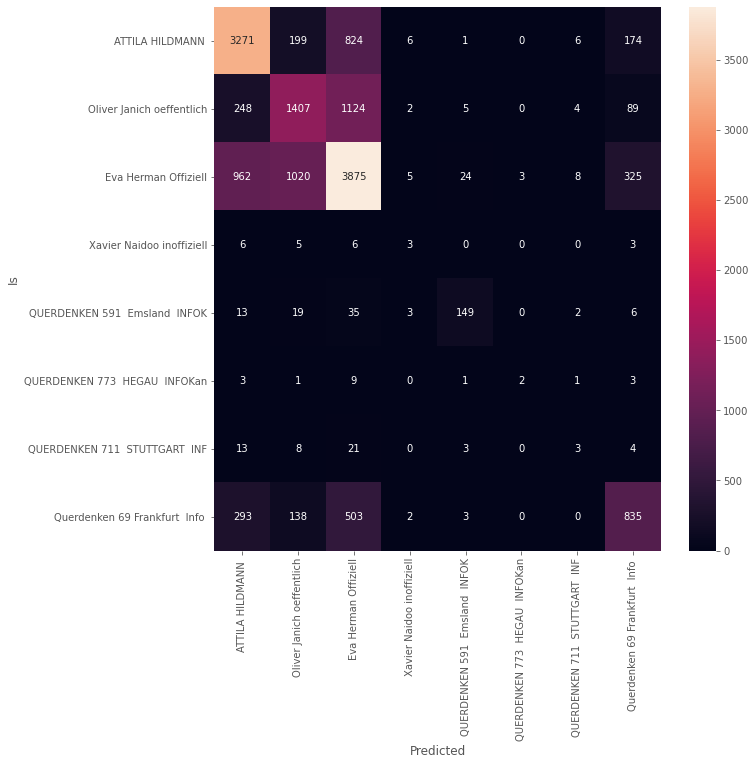

In [28]:
trainAndEvalModel(DecisionTreeClassifier(), "class-decisiontree.svg")

[Stopwatch started >>- Train now model RandomForestClassifier()<<]

[Stopwatch stopped >>- Train now model RandomForestClassifier()<< (1659.297s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['ATTILA HILDMANN ']

Train Score:	0.9632907557128961

Test Score:	0.6891822936599056

Confusion Matrix on test:

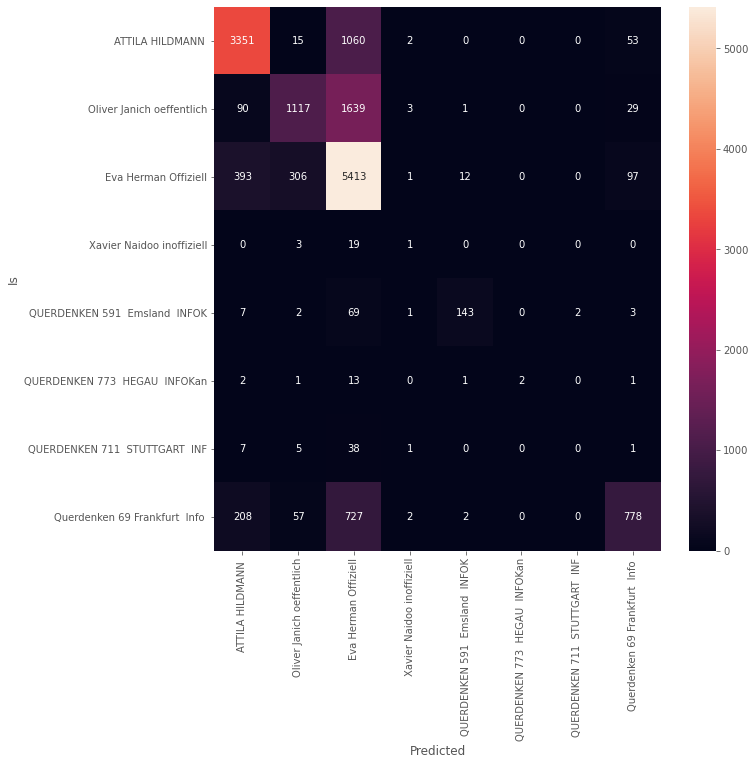

In [29]:
trainAndEvalModel(RandomForestClassifier(), "class-randomforest.svg")

[Stopwatch started >>- Train now model DummyClassifier()<<]

[Stopwatch stopped >>- Train now model DummyClassifier()<< (0.054s)]

Who has written 'Folge Attila Hildmann'?

['Oliver Janich oeffentlich']

Who has written 'Liebe Eva'?

['Oliver Janich oeffentlich']

Who has written 'Premium Kanal'?

['Oliver Janich oeffentlich']

Train Score:	0.39098056100400264

Test Score:	0.39686184462303864

Confusion Matrix on test:

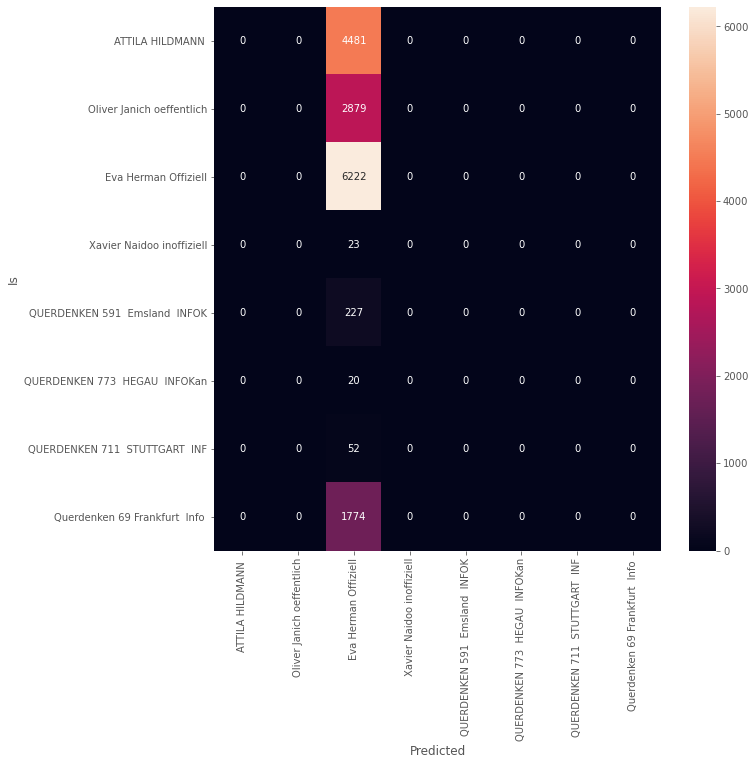

In [30]:
trainAndEvalModel(DummyClassifier(), "class-dummy.svg")